# Analyse des dialogues dans l'Avare de Molière

## Choix du fichier source

*L'Avare* de Molière est disponible dans plusieurs formats différents. 
Cependant, tous ne se prêtent pas à une analyse sémantique d'une pièce de théâtre. 
Les formats reposant sur du texte brut (tels que Markdown ou iramuteq, et par extension, les fichiers ne contenant que les prises de parole) compliquent le triage des [didascalies](https://fr.wikipedia.org/wiki/Didascalie_(théâtre)) et autres blocs de texte insérés dans les scènes, et ne relevant pas directement du dialogue. 
Notre choix devra donc se porter sur un format plus structuré.
Nous pourrions tenter l'analyse des fichiers epub ou kindle, mais ce sont des formats destinés à la présentation, ce qui rendrait leur analyse inutilement complexe et coûteuse, alors que de meilleurs formats sont disponibles.

Les formats de fichier constituant de meilleurs candidats pour une analyse sémantique sont basés sur XML, qui permet la structuration du contenu : TEI (conçu par le *Text Encoding Initiative Consortium*), TXM (co-développé par l'École normale supérieure de Lyon et l'université de Franche-Comté), et HTML (le langage de balisage du web). 

Ces trois formats sont basés sur XML, et peuvent donc théoriquement être exploités avec une même API ([XPath](https://fr.wikipedia.org/wiki/XPath)), sans nécessiter de bibliothèque tierce. 

HTML présente toutefois des avantages considérables : son exploitation par, au minimum, quelques centaines de millions de sites web à travers le monde, et sa gouvernance par un consortium d'entreprises comme Apple, Google ou Mozilla outre-Atlantique, ou encore l'Inria en France. 
C'est le format qui a créé internet, et il est réutilisé dans des contextes très différents.
De plus, en tant que développeur web depuis 30 ans, l'auteur de la présente analyse ne cache pas son intérêt particulier pour ce format, avec lequel il est bien plus familier qu'avec les autres.

Nous poursuivrons donc cette étude avec le fichier `moliere_avare.html` [mis à disposition](http://dramacode.github.io/html/moliere_avare.html) par [dramacode](https://dramacode.github.io).

## Ouverture du fichier

Commençons par regrouper les importations, afin d'en avoir une vue d'ensemble.

In [1]:
# Parseur XML, requêtes XPath
import xml.etree.ElementTree as ET

# Analyse
import pandas as pd

# Utile pour la gestion des caractères accentués
import locale

# Nous permet de combiner deux listes de longueur indéterminée
from itertools import zip_longest

# Utilisation d'expressions régulières (regex)
import re

# Traçage de graphiques
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Permet de définir et d'afficher la colormap des personnages
from itertools import cycle
import matplotlib.patches as mpatches

# Utiles aux calculs effectués pour les graphiques
import math
import numpy as np

# Graphe réseau
import networkx as nx
import bokeh.plotting as bkp
from bokeh.io import output_notebook, show
from bokeh.resources import INLINE
from bokeh.models import (
    GraphRenderer,
    StaticLayoutProvider,
    Circle,
    MultiLine,
    HoverTool,
    Arrow,
    NormalHead,
    ColumnDataSource,
    LabelSet,
)

In [2]:
# Directive pour bokeh pour inclure le graphe réseau final dans le notebook
output_notebook()

Loading BokehJS ...

In [3]:
# La définition de la locale nous permettra de gérer correctement les majuscules
# accentuées
# locale.setlocale(locale.LC_COLLATE, "fr_FR.UTF-8")  # ou "fr_FR.UTF-8", "fr_FR" selon le système

ns = {"x": "http://www.w3.org/1999/xhtml"}
root = ET.parse("moliere_avare.html").getroot()

## Outils préliminaires

Nous travaillons sur une pièce de théâtre, par définition divisée en actes et en scènes.
Nous allons donc nous créer quelques outils pour accéder facilement à ces éléments structurés, que nous complèterons de diverses fonctions utilisées à plusieurs reprises dans notre étude.

In [4]:
# Nettoyage des titres
def clean_title(el, tag):
    return "".join(el.find(tag, ns).itertext()).replace("§", "").strip()

# Actes avec ordre explicite
def list_acts():
    acts = []

    for idx, act in enumerate(root.findall(".//x:section[@class='div1 act level2']", ns)):
        acts.append({
            "id": act.get("id"),
            "title": clean_title(act, "x:h2"),
            "node": act,
            "order": idx,
        })

    return acts

# Scènes d’un acte donné, avec ordre explicite
def list_scenes(act=None, act_id=None):
    if act is None:
        if act_id is None:
            raise ValueError("Un élément `act` ou un identifiant doit être spécifié")

        act = root.find(f".//x:section[@class='div1 act level2'][@id='{act_id}']", ns)

        if act is None:
            raise ValueError(f"Acte introuvable: {act_id}")

    scenes = []

    for idx, scene in enumerate(act.findall("x:section[@class='div2 scene level3']", ns)):
        scenes.append({
            "id": scene.get("id"),
            "title": clean_title(scene, "x:h3"),
            "node": scene,
            "order": idx,
        })

    return scenes

# On compacte les espaces pour calquer le comptage sur l'OBVIL
# Supprime les balises <i> de l'élément HTML soumis.
# Cela permet de ne conserver que les noms de personnages extraits des blocs de dialogue,
# sans les didascalies.
def text_without_i(el):
    parts = []

    if el.tag != f"{{{ns['x']}}}i" and el.text and el.text.strip():
        parts.append(el.text.strip())

    for child in el:
        if child.tag != f"{{{ns['x']}}}i":
            parts.extend(text_without_i(child))

        # on garde toujours le texte suivant, même si le noeud enfant est une balise <i>
        if child.tail and child.tail.strip():
            parts.append(child.tail.strip())

    return parts

# Formate le nom d'un acteur extrait d'un dialogue
def speaker_name(sp):
    name = " ".join(text_without_i(sp)).strip()

    # nettoyage simple de la ponctuation finale
    name = name.rstrip(",;:").strip()

    return name

# Résolution d'un nom d'acteur à partir de notre table de correspondance
alias_index = {}
def resolve_name(name):
    return alias_index.get(name, name)

# Extrait le texte brut d'un dialogue soumis sous la forme d'un élément HTML
def speech_text(sp):
    parts = []

    for p in sp.findall(".//x:p[@class='p autofirst']", ns):
        parts.extend(text_without_i(p))

    raw = " ".join(parts)
    return " ".join(raw.split()).strip()

# Compte le nombre de mots d'un texte brut.
# On utilise ici une regex simple dédiée à cet usage.
def word_count(txt):
    return len(re.findall(r"\b\w+\b", txt, flags=re.UNICODE))

# Conversion d'un texte en nombre de lignes (60 caractères par ligne)
def line_count(txt, line_length=60):
    return len(txt) / line_length if txt else 0

# Retourne l'acteur associé à une réplique (<div class="sp">)
def speech_actor(sp):
    speaker_el = sp.find("x:p[@class='speaker']", ns)

    if speaker_el is None:
        return ""

    return resolve_name(speaker_name(speaker_el))

# Liste les répliques d'une scène (par noeud ou identifiant) avec texte et nombre de mots
def scene_speeches(scene=None, scene_id=None):
    if scene is None:
        if scene_id is None:
            raise ValueError("Un élément `scene` ou un identifiant doit être spécifié")

        scene = root.find(f".//x:section[@class='div2 scene level3'][@id='{scene_id}']", ns)

        if scene is None:
            raise ValueError(f"Scène introuvable: {scene_id}")

    speeches = []

    for sp_div in scene.findall(".//x:div[@class='sp']", ns):
        speaker = speech_actor(sp_div)

        if not speaker:
            continue

        txt = speech_text(sp_div)

        speeches.append({
            "speaker": speaker,
            "text": txt,
            "word_count": word_count(txt),
            "node": sp_div,
        })

    return speeches

# Création d'une colormap associant une couleur à un personnage
def create_actors_colormap(personnages):
    # Définition d'une palette de couleurs pour les personnages
    palette = cycle(plt.cm.tab20.colors)
    color_map = {}

    for p in personnages:
        color_map[p] = next(palette)

    return color_map

Vérifions que nous obtenons bien la liste des actes et des scènes :

In [5]:
for act in list_acts():
    for scene in list_scenes(act=act["node"]):
        print ("Acte " + act["id"] + " - Scène " + scene["id"])

Acte I - Scène I01
Acte I - Scène I02
Acte I - Scène I03
Acte I - Scène I04
Acte I - Scène I05
Acte II - Scène II01
Acte II - Scène II02
Acte II - Scène II03
Acte II - Scène II04
Acte II - Scène II05
Acte III - Scène III01
Acte III - Scène III02
Acte III - Scène III03
Acte III - Scène III04
Acte III - Scène III05
Acte III - Scène III06
Acte III - Scène III07
Acte III - Scène III08
Acte III - Scène III09
Acte IV - Scène IV01
Acte IV - Scène IV02
Acte IV - Scène IV03
Acte IV - Scène IV04
Acte IV - Scène IV05
Acte IV - Scène IV06
Acte IV - Scène IV07
Acte V - Scène V01
Acte V - Scène V02
Acte V - Scène V03
Acte V - Scène V04
Acte V - Scène V05
Acte V - Scène V06


## Obtention de la liste des acteurs

La requête xpath suivante permet d'extraire la liste des acteurs donnée au début du fichier, autrement appelée [_dramatis personae_](https://fr.wikipedia.org/wiki/Dramatis_personæ_(théâtre)).

In [6]:
# Retourne une liste formatée des personnages définis dans la dramatis personae.
# Prend en compte les majuscules accentuées.
def dramatis_personae():
    rows = []

    # Requête xpath permettant d'obtenir la liste des balises <li> listant les acteurs
    for li in root.findall(".//x:div[@id='castList']//x:li", ns):
        # L'acteur se trouve dans une balise <span>
        span = li.find("x:span", ns)
        name = span.text.strip()

        # description = texte qui suit le <span> dans la même balise <li>
        desc = (span.tail or "").strip()

        if desc.startswith(","):
            desc = desc[1:].strip()

        rows.append({"Personnage": name, "Description": desc})

    return pd.DataFrame(rows)

dramatis_personae = dramatis_personae()

# Affichage de la liste
dramatis_personae

Description      Personnage
0   Père de Cléante et d'Élise, et Amoureux de Mar...        Harpagon
1                  Fils d'Harpagon, Amant de Mariane.         Cléante
2                 Fille d'Harpagon, Amante de Valère.           Élise
3                   Fils d'Anselme, et Amant d'Élise.          Valère
4             Amante de Cléante, et aimée d'Harpagon.         Mariane
5                       Père de Valère et de Mariane.         Anselme
6                                   Femme d'Intrigue.         Frosine
7                                           Courtier.    Maitre Simon
8                     Cuisinier et Cocher d'Harpagon.  Maitre Jacques
9                                   Valet de Cléante.       La Flèche
10                               Servante d'Harpagon.     Dame Claude
11                                laquais d'Harpagon.     Brindavoine
12                                laquais d'Harpagon.     La Merluche
13                                      et son clerc.  Le commissaire

Nous pouvons déjà constater que le commissaire et son clerc sont considérés comme un acteur unique.
Nous verrons plus tard si cette information est importante (par exemple, si le clerc s'exprime en son nom propre).

Nous allons confronter cette liste avec la liste des protagonistes mentionnés en introduction de chaque scène, puis avec ceux qui interviennent "réellement", c'est-à-dire ceux qui ont une ligne de dialogue.
Cette étape devra nous permettre d'identifier des différences d'orthographe subtiles qu'il sera utile de gérer.

### Noms des personnages par scène

Nous allons itérer sur chaque acte, puis chaque scène, afin de consulter la liste des protagonistes. 
N'oublions pas que ces listes sont facultatives, et ne désignent pas les acteurs dotés d'une réplique.
Néanmoins, nous pourrions identifier des éléments potentiellement intéressants, tels que des orthographes différentes ou une anomalie quelconque.

In [7]:
def list_scene_protagonists():
    rows = []

    for act in list_acts():
        for scene in list_scenes(act=act["node"]):
            stage = scene["node"].find("x:div[@class='stage stage']", ns)

            # Si nous trouvons un noeud xpath pour cette requête, c'est un personnage
            if stage is not None:
                raw = "".join(stage.itertext()).strip()
                people = [p.strip() for p in raw.split(",") if p.strip()]
            else:
                people = []

            rows.append({
                "Acte": act["title"],
                "Scène": scene["title"],
                "Protagonistes": people,
            })

    return pd.DataFrame(rows)

df_scenes = list_scene_protagonists()
df_scenes

Acte                                      Protagonistes  \
0   Acte Premier                                    [Valère, Élise]   
1   Acte Premier                                   [Cléante, Élise]   
2   Acte Premier                              [Harpagon, La Flèche]   
3   Acte Premier                         [Élise, Cléante, Harpagon]   
4   Acte Premier                          [Valère, Harpagon, Élise]   
5        Acte II                               [Cléante, La Flèche]   
6        Acte II       [Maître Simon, Harpagon, Cléante, La Flèche]   
7        Acte II                                [Frosine, Harpagon]   
8        Acte II                               [La Flèche, Frosine]   
9        Acte II                                [Harpagon, Frosine]   
10      Acte III  [Harpagon, Cléante, Élise, Valère, Dame Claude...   
11      Acte III                           [Maître Jacques, Valère]   
12      Acte III                 [Frosine, Mariane, Maître Jacques]   
13      Acte III                                 [Mariane, Frosine]   
14      Acte III                       [Harpagon, Frosine, Mariane]   
15      Acte III                [Élise, Harpagon, Mariane, Frosine]   
16      Acte III       [Cléante, Harpagon, Élise, Mariane, Frosine]   
17      Acte III  [Harpagon, Mariane, Frosine, Cléante, Brindavo...   
18      Acte III  [Harpagon, Mariane, Cléante, Élise, Frosine, L...   
19       Acte IV                 [Cléante, Mariane, Élise, Frosine]   
20       Acte IV       [Harpagon, Cléante, Mariane, Élise, Frosine]   
21       Acte IV                                [Harpagon, Cléante]   
22       Acte IV                [Maître Jacques, Harpagon, Cléante]   
23       Acte IV                                [Cléante, Harpagon]   
24       Acte IV                               [La Flèche, Cléante]   
25       Acte IV                                                 []   
26        Acte V              [Harpagon, Le Commissaire, son Clerc]   
27        Acte V  [Maître Jacques, Harpagon, Le Commissaire, son...   
28        Acte V  [Valère, Harpagon, le Commissaire, son Clerc, ...   
29        Acte V  [Élise, Mariane, Frosine, Harpagon, Valère, Ma...   
30        Acte V  [Anselme, Harpagon, Élise, Mariane, Frosine, V...   
31        Acte V  [Cléante, Valère, Mariane, Élise, Frosine, Har...   

             Scène  
0   Scène Première  
1         Scène II  
2        Scène III  
3         Scène IV  
4          Scène V  
5   Scène Première  
6         Scène II  
7        Scène III  
8         Scène IV  
9          Scène V  
10  Scène Première  
11        Scène II  
12       Scène III  
13        Scène IV  
14         Scène V  
15        Scène VI  
16       Scène VII  
17      Scène VIII  
18        Scène IX  
19  Scène Première  
20        Scène II  
21       Scène III  
22        Scène IV  
23         Scène V  
24        Scène VI  
25       Scène VII  
26  Scène Première  
27        Scène II  
28       Scène III  
29        Scène IV  
30         Scène V  
31        Scène VI

Nous voyons ici que la scène VII de l'acte IV ne contient aucun protagoniste déclaré dans la liste attenante[^1], mais nous allons de toute façon la compléter par l'extraction individuelle des interventions concrètes de chaque acteur.

[^1]: Cette liste n'est pas obligatoire dans le contexte théâtral. Ici, on peut supposer que son absence est dûe à un monologue par exemple.

In [8]:
def list_scene_speakers():
    rows = []

    for act in list_acts():
        for scene in list_scenes(act=act["node"]):
            speakers, seen = [], set()

            for sp in scene["node"].findall(".//x:p[@class='speaker']", ns):
                name = speaker_name(sp)

                # On évite d'ajouter à la liste un acteur que l'on a déjà vu passer
                if name and name not in seen:
                    seen.add(name)
                    speakers.append(name)

            rows.append({
                "Acte": act["title"],
                "Scène": scene["title"],
                "Intervenants": speakers,
            })

    return pd.DataFrame(rows)

df_speakers = list_scene_speakers()
df_speakers

Acte                                       Intervenants  \
0   Acte Premier                                    [Valère, Élise]   
1   Acte Premier                                   [Cléante, Élise]   
2   Acte Premier                              [Harpagon, La Flèche]   
3   Acte Premier                         [Harpagon, Cléante, Élise]   
4   Acte Premier                          [Harpagon, Valère, Élise]   
5        Acte II                               [Cléante, La Flèche]   
6        Acte II       [Maître simon, Harpagon, La Flèche, Cléante]   
7        Acte II                                [Frosine, Harpagon]   
8        Acte II                               [La Flèche, Frosine]   
9        Acte II                                [Harpagon, Frosine]   
10      Acte III  [Harpagon, Maître Jacques, La Merluche, Brinda...   
11      Acte III                           [Valère, Maître Jacques]   
12      Acte III                          [Frosine, Maître Jacques]   
13      Acte III                                 [Mariane, Frosine]   
14      Acte III                                [Harpagon, Frosine]   
15      Acte III                [Mariane, Élise, Harpagon, Frosine]   
16      Acte III      [Cléante, Mariane, Harpagon, Frosine, Valère]   
17      Acte III                            [Brindavoine, Harpagon]   
18      Acte III           [La Merluche, Harpagon, Cléante, Valère]   
19       Acte IV                 [Cléante, Élise, Mariane, Frosine]   
20       Acte IV                         [Harpagon, Élise, Cléante]   
21       Acte IV                                [Harpagon, Cléante]   
22       Acte IV                [Maître Jacques, Cléante, Harpagon]   
23       Acte IV                                [Cléante, Harpagon]   
24       Acte IV                               [La Flèche, Cléante]   
25       Acte IV                                         [Harpagon]   
26        Acte V                         [Le Commissaire, Harpagon]   
27        Acte V         [Maître Jacques, Harpagon, Le Commissaire]   
28        Acte V                 [Harpagon, Valère, Maître Jacques]   
29        Acte V  [Harpagon, Valère, Élise, Maître Jacques, Fros...   
30        Acte V  [Anselme, Harpagon, Valère, Mariane, Maître Ja...   
31        Acte V  [Cléante, Harpagon, Mariane, Anselme, Le Commi...   

             Scène  
0   Scène Première  
1         Scène II  
2        Scène III  
3         Scène IV  
4          Scène V  
5   Scène Première  
6         Scène II  
7        Scène III  
8         Scène IV  
9          Scène V  
10  Scène Première  
11        Scène II  
12       Scène III  
13        Scène IV  
14         Scène V  
15        Scène VI  
16       Scène VII  
17      Scène VIII  
18        Scène IX  
19  Scène Première  
20        Scène II  
21       Scène III  
22        Scène IV  
23         Scène V  
24        Scène VI  
25       Scène VII  
26  Scène Première  
27        Scène II  
28       Scène III  
29        Scène IV  
30         Scène V  
31        Scène VI

In [9]:
# Tri localisé pour les intervenants et déduplication
intervenants_uniques = sorted(
    {name for names in df_speakers["Intervenants"] for name in names},
    key=locale.strxfrm
)

intervenants_df = pd.DataFrame({"Intervenant": intervenants_uniques})
intervenants_df

Intervenant
0          Anselme
1      Brindavoine
2          Cléante
3          Frosine
4         Harpagon
5        La Flèche
6      La Merluche
7   Le Commissaire
8          Mariane
9   Maître Jacques
10    Maître simon
11          Valère
12           Élise

On peut désormais identifier les différences avec la _dramatis personae_, afin de vérifier l'uniformité des orthographes.
Par corollaire, on pourra, en même temps, identifier les acteurs sans réplique.

In [10]:
acteurs_set = set(dramatis_personae["Personnage"])
intervenants_set = set(intervenants_uniques)

# On écarte les noms exactement identiques
communs = acteurs_set & intervenants_set
acteurs_only = sorted(acteurs_set - communs, key=locale.strxfrm)
intervenants_only = sorted(intervenants_set - communs, key=locale.strxfrm)

df_diff = pd.DataFrame(
    list(zip_longest(acteurs_only, intervenants_only)),
    columns=["Personnage (en-tête)", "Intervenant (répliques)"]
)

df_diff

Personnage (en-tête) Intervenant (répliques)
0          Dame Claude          Le Commissaire
1       Le commissaire          Maître Jacques
2       Maitre Jacques            Maître simon
3         Maitre Simon                    None

`None` indique simplement un remplissage par `zip_longest` pour que les deux listes aient la même taille.

On identifie bien deux orthographes différentes pour trois acteurs. La liste des personnages initiale omet les accents circonflexes de "Maître", "commissaire" est écrit en minuscule, et "Simon" a perdu sa majuscule.

Enfin, il est clair que Dame Claude n'a aucune réplique (puisqu'on ne la retrouve pas dans la liste des intervenants).

On peut donc créer une table de correspondance, associant un nom correctement orthographié avec les variantes que l'on peut trouver dans le texte initial. Nous utiliserons comme référence la graphie française correcte de "maître", et "Commissaire" avec une majuscule.

In [11]:
alias_map = {
    "Maître Jacques": {"Maître Jacques", "Maitre Jacques"},
    "Maître Simon": {"Maitre Simon", "Maître simon"},
    "Le Commissaire": {"Le Commissaire", "Le commissaire"},
}

alias_index = {alias: canon for canon, aliases in alias_map.items() for alias in aliases}

## Quantité de parole par acteur

Maintenant que nous disposons d'une liste uniformisée des noms des différents acteurs, nous pouvons analyser l'ensemble de la pièce et quantifier le texte prononcé par chaque acteur.

In [12]:
# TODO : Est-ce que cette fonction est redondante avec
# les fonctions utilitaires créées précédemment ?
def count_words_by_actor():
    rows = []

    for act in list_acts():
        for scene in list_scenes(act=act["node"]):
            for order, speech in enumerate(scene_speeches(scene=scene["node"])):
                txt = speech["text"]
                rows.append({
                    "Acte": act["title"],
                    "Scène": scene["title"],
                    "Ordre": order,
                    "Personnage": speech["speaker"],
                    "Texte": txt,
                    "Mots": speech["word_count"],
                    "Lignes": line_count(txt),
                })

    return pd.DataFrame(rows)

df_speeches = count_words_by_actor()
df_counts = df_speeches.groupby(["Acte", "Scène", "Personnage"], as_index=False)["Mots"].sum()
df_counts

Acte           Scène      Personnage  Mots
0        Acte II        Scène II         Cléante   127
1        Acte II        Scène II        Harpagon   171
2        Acte II        Scène II       La Flèche    12
3        Acte II        Scène II    Maître Simon   197
4        Acte II       Scène III         Frosine     1
5        Acte II       Scène III        Harpagon    21
6        Acte II        Scène IV         Frosine   130
7        Acte II        Scène IV       La Flèche   292
8        Acte II  Scène Première         Cléante   379
9        Acte II  Scène Première       La Flèche   903
10       Acte II         Scène V         Frosine  1482
11       Acte II         Scène V        Harpagon   555
12      Acte III        Scène II  Maître Jacques   186
13      Acte III        Scène II          Valère    92
14      Acte III       Scène III         Frosine    19
15      Acte III       Scène III  Maître Jacques    11
16      Acte III        Scène IV         Frosine   191
17      Acte III        Scène IV         Mariane   185
18      Acte III        Scène IX         Cléante    40
19      Acte III        Scène IX        Harpagon    73
20      Acte III        Scène IX     La Merluche    21
21      Acte III        Scène IX          Valère     7
22      Acte III  Scène Première     Brindavoine    23
23      Acte III  Scène Première         Cléante    76
24      Acte III  Scène Première        Harpagon   747
25      Acte III  Scène Première     La Merluche    26
26      Acte III  Scène Première  Maître Jacques   779
27      Acte III  Scène Première          Valère   249
28      Acte III  Scène Première           Élise     3
29      Acte III         Scène V         Frosine    26
..           ...             ...             ...   ...
65  Acte Premier        Scène IV           Élise   162
66  Acte Premier  Scène Première          Valère   630
67  Acte Premier  Scène Première           Élise   491
68  Acte Premier         Scène V        Harpagon   271
69  Acte Premier         Scène V          Valère   701
70  Acte Premier         Scène V           Élise    36
71        Acte V        Scène II        Harpagon   182
72        Acte V        Scène II  Le Commissaire   159
73        Acte V        Scène II  Maître Jacques   348
74        Acte V       Scène III        Harpagon   441
75        Acte V       Scène III  Maître Jacques    11
76        Acte V       Scène III          Valère   641
77        Acte V        Scène IV         Frosine     4
78        Acte V        Scène IV        Harpagon   124
79        Acte V        Scène IV  Maître Jacques     7
80        Acte V        Scène IV          Valère    22
81        Acte V        Scène IV           Élise   143
82        Acte V  Scène Première        Harpagon    89
83        Acte V  Scène Première  Le Commissaire   109
84        Acte V         Scène V         Anselme   403
85        Acte V         Scène V        Harpagon   258
86        Acte V         Scène V         Mariane   192
87        Acte V         Scène V  Maître Jacques     7
88        Acte V         Scène V          Valère   376
89        Acte V        Scène VI         Anselme   114
90        Acte V        Scène VI         Cléante   130
91        Acte V        Scène VI        Harpagon    89
92        Acte V        Scène VI  Le Commissaire    26
93        Acte V        Scène VI         Mariane    36
94        Acte V        Scène VI  Maître Jacques    23

[95 rows x 4 columns]

Le comptage semble s'effectuer correctement, mais un tel tableau n'est pas digeste. 
On peut noter par exemple que "Acte Premier" est dilué au centre du tableau, en raison de la clause `groupby`, qui trie implicitement le tableau, et ignore donc notre tri initial.
Nous pouvons toutefois ignorer ce détail ici, et regrouper par personnage : de cette manière, nous aurons un aperçu global du temps de parole de chacun à travers l'oeuvre.

In [13]:
global_df = df_speeches.groupby(["Personnage"])["Mots"].sum()

moins_bavard_nom = global_df.idxmin()
moins_bavard_mots = global_df.min()

plus_bavard_nom = global_df.idxmax()
plus_bavard_mots = global_df.max()

print(f"Personnage le plus taciturne : {moins_bavard_nom} ({moins_bavard_mots} mots)")
print(f"Personnage le plus locace  : {plus_bavard_nom} ({plus_bavard_mots} mots)")

Personnage le plus taciturne : Brindavoine (43 mots)
Personnage le plus locace  : Harpagon (6132 mots)


Notons que nous avons déjà établi que Dame Claude n'avait aucune réplique, et bien que le Commissaire soit accompagné d'un clerc, ce dernier ne parle jamais non plus.

Montrons la proportion de dialogues par personnage à travers un diagramme circulaire :

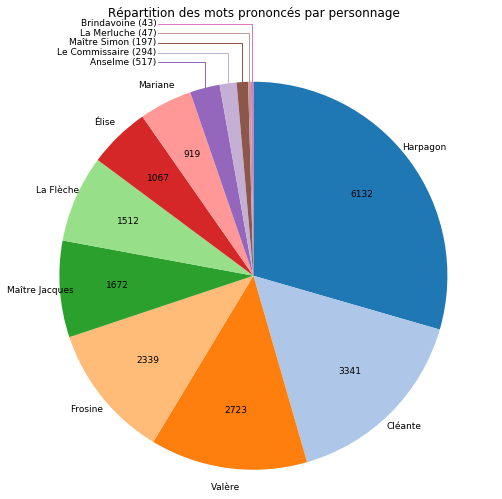

In [14]:
n_small = 5
y0, dy = 1.3, 0.05   # Positionnement du bloc des acteurs les moins locaces
x_col = -0.5

totaux = df_speeches.groupby("Personnage")["Mots"].sum().sort_values(ascending=False)
labels = totaux.index
values = totaux.values
color_map = create_actors_colormap(labels)
colors = [color_map[p] for p in labels]

fig, ax = plt.subplots(figsize=(7, 7))
wedges, _ = ax.pie(values, colors=colors, startangle=90, counterclock=False)

small_roles = global_df.sort_values().head(n_small)  # les moins bavards, ordre croissant

# Placement de l'étiquette pour les petits rôles
for i, (name, val) in enumerate(small_roles.items()):
    idx = labels.get_loc(name)
    w = wedges[idx]

    theta = np.deg2rad((w.theta1 + w.theta2) / 2)
    xw, yw = np.cos(theta), np.sin(theta)
    xpos, ypos = x_col, y0 - i * dy

    ax.annotate(
        f"{name} ({val})",
        xy=(xw, yw), xytext=(xpos, ypos),
        ha="right", va="center", fontsize=9,
        arrowprops=dict(
            arrowstyle="-",
            color=colors[idx],
            lw=1,
            connectionstyle="angle,angleA=0,angleB=90",
            shrinkA=0, shrinkB=0,
        ),
    )

# Autres rôles : nom autour + valeur au centre
for idx, name in enumerate(labels):
    if name in small_roles.index:
        continue

    w = wedges[idx]
    theta = np.deg2rad((w.theta1 + w.theta2) / 2)
    r_label, r_value = 1.1, 0.7

    ax.text(r_label * np.cos(theta), r_label * np.sin(theta), name, ha="center", va="center", fontsize=9)
    ax.text(r_value * np.cos(theta), r_value * np.sin(theta), str(totaux[name]), ha="center", va="center", fontsize=9, color="black")

ax.set_title("Répartition des mots prononcés par personnage", pad=50)
ax.axis("equal")
plt.tight_layout()


### Statistiques complémentaires

Inspirées des tableaux de l'OBVIL, nous examinons la place de chaque personnage et les relations directes entre interlocuteurs (une ligne = 60 caractères).
Commençons par la "Table des rôles" :

In [15]:
# Agrégats au niveau des scènes
scene_totals = (
    df_speeches
    .groupby(["Acte", "Scène"], as_index=False)
    .agg({
        "Lignes": "sum",
        "Personnage": "nunique",
    })
)

scene_totals = scene_totals.rename(columns={
    "Lignes": "scene_lines",
    "Personnage": "participants",
})

scene_totals["textexpers"] = scene_totals["scene_lines"] * scene_totals["participants"]
scene_totals["SceneKey"] = scene_totals["Acte"] + " | " + scene_totals["Scène"]

total_lines_play = scene_totals["scene_lines"].sum()
textexpers_total = scene_totals["textexpers"].sum()

# Statistiques par personnage
speech_stats = (
    df_speeches
    .groupby("Personnage")
    .agg({
        "Texte": "count",
        "Lignes": "sum",
    })
    .rename(columns={
        "Texte": "repl",
        "Lignes": "text_lines",
    })
)

presence = (
    df_speeches[["Acte", "Scène", "Personnage"]]
    .drop_duplicates()
    .merge(
        scene_totals[["Acte", "Scène", "scene_lines", "textexpers"]],
        on=["Acte", "Scène"],
        how="left",
    )
)

presence_stats = (
    presence
    .groupby("Personnage")
    .agg({
        "Scène": "count",
        "scene_lines": "sum",
        "textexpers": "sum",
    })
    .rename(columns={
        "Scène": "scenes",
        "scene_lines": "presence_lines",
    })
)

roles = speech_stats.join(presence_stats, how="outer").fillna(0)

# Ajout des rôles muets (ex : Dame Claude) pour qu'ils apparaissent dans le tableau
for name in (resolve_name(p) for p in dramatis_personae["Personnage"]):
    if name not in roles.index:
        roles.loc[name] = 0

roles["repl_moy"] = roles["text_lines"] / roles["repl"]
roles["presence_pct"] = roles["presence_lines"] / total_lines_play
roles["text_pct"] = roles["text_lines"] / total_lines_play
roles["text_presence_pct"] = roles["text_lines"] / roles["presence_lines"]
roles["textexpers_pct"] = roles["textexpers"] / textexpers_total
roles["interlocution"] = roles["textexpers"] / roles["presence_lines"]

roles = roles.replace([np.inf, -np.inf], 0).fillna(0)

# Ordre basé sur la distribution initiale
role_order = [
    name for name in (resolve_name(p) for p in dramatis_personae["Personnage"])
    if name in roles.index
]
role_order += [r for r in roles.index if r not in role_order]

roles = roles.loc[role_order]

# Ligne globale
all_row = pd.Series({
    "scenes": scene_totals.shape[0],
    "repl": len(df_speeches),
    "repl_moy": df_speeches["Lignes"].sum() / len(df_speeches),
    "presence_lines": total_lines_play,
    "presence_pct": 1.0,
    "text_lines": df_speeches["Lignes"].sum(),
    "text_pct": 1.0,
    "text_presence_pct": (
        df_speeches["Lignes"].sum() / total_lines_play if total_lines_play else 0
    ),
    "textexpers": textexpers_total,
    "textexpers_pct": 1.0,
    "interlocution": textexpers_total / total_lines_play if total_lines_play else 0,
})

roles = pd.concat([
    pd.DataFrame({"Personnage": ["[TOUS]"]})
      .set_index("Personnage")
      .assign(**all_row),
    roles,
])

roles.index.name = "Rôle"

# Quelques utilitaires spécifiques

def format_number(value, decimals=0):
    fmt = f"{value:,.{decimals}f}"
    return fmt.replace(",", " ").replace(".", ",")

def format_lines(value, decimals=0):
    return f"{format_number(round(value, decimals), decimals)} l."

def format_percent(value, decimals=0):
    return f"{format_number(value * 100, decimals)} %"

def format_people(value):
    return f"{format_number(value, 1)} pers."

roles_display = roles.reset_index()
roles_display["Scènes"] = roles_display["scenes"].fillna(0).astype(int).astype(str) + " sc."
roles_display["Répl."] = roles_display["repl"].fillna(0).astype(int).astype(str) + " répl."
roles_display["Répl. moy."] = roles_display["repl_moy"].apply(lambda v: format_lines(v, 1))
roles_display["Présence"] = roles_display.apply(
    lambda r: f"{format_lines(r['presence_lines'])}"
              + (f" ({format_percent(r['presence_pct'])})" if r["presence_lines"] else ""),
    axis=1,
)
roles_display["Texte"] = roles_display.apply(
    lambda r: f"{format_lines(r['text_lines'])}"
              + (f" ({format_percent(r['text_pct'])})" if r["text_lines"] else ""),
    axis=1,
)
roles_display["Texte % prés."] = roles_display["text_presence_pct"].apply(lambda v: format_percent(v, 0))
roles_display["Texte × pers."] = roles_display.apply(
    lambda r: f"{format_lines(r['textexpers'])} ({format_percent(r['textexpers_pct'])})",
    axis=1,
)
roles_display["Interlocution"] = roles_display["interlocution"].apply(format_people)

roles_table = roles_display[
    ["Rôle", "Scènes", "Répl.", "Répl. moy.", "Présence",
     "Texte", "Texte % prés.", "Texte × pers.", "Interlocution"]
]

roles_table


Rôle  Scènes      Répl. Répl. moy.          Présence  \
0           [TOUS]  32 sc.  959 répl.     1,8 l.  1 769 l. (100 %)   
1         Harpagon  23 sc.  354 répl.     1,5 l.   1 296 l. (73 %)   
2          Cléante  14 sc.  161 répl.     1,8 l.     900 l. (51 %)   
3            Élise   9 sc.   51 répl.     1,8 l.     681 l. (39 %)   
4           Valère   9 sc.  101 répl.     2,3 l.     695 l. (39 %)   
5          Mariane   6 sc.   31 répl.     2,5 l.     359 l. (20 %)   
6          Anselme   2 sc.   20 répl.     2,3 l.      143 l. (8 %)   
7          Frosine  10 sc.   60 répl.     3,3 l.     466 l. (26 %)   
8     Maître Simon   1 sc.    5 répl.     3,2 l.       44 l. (2 %)   
9   Maître Jacques   9 sc.   85 répl.     1,6 l.     557 l. (32 %)   
10       La Flèche   5 sc.   66 répl.     2,0 l.     255 l. (14 %)   
11     Dame Claude   0 sc.    0 répl.     0,0 l.              0 l.   
12     Brindavoine   2 sc.    3 répl.     1,1 l.      166 l. (9 %)   
13     La Merluche   2 sc.    5 répl.     0,9 l.     175 l. (10 %)   
14  Le Commissaire   3 sc.   17 répl.     1,5 l.      110 l. (6 %)   

               Texte Texte % prés.     Texte × pers. Interlocution  
0   1 769 l. (100 %)         100 %  5 847 l. (100 %)     3,3 pers.  
1      514 l. (29 %)          40 %   4 729 l. (81 %)     3,7 pers.  
2      285 l. (16 %)          32 %   3 486 l. (60 %)     3,9 pers.  
3        92 l. (5 %)          13 %   2 667 l. (46 %)     3,9 pers.  
4      232 l. (13 %)          33 %   3 067 l. (52 %)     4,4 pers.  
5        79 l. (4 %)          22 %   1 638 l. (28 %)     4,6 pers.  
6        45 l. (3 %)          32 %     749 l. (13 %)     5,3 pers.  
7      201 l. (11 %)          43 %   1 465 l. (25 %)     3,1 pers.  
8        16 l. (1 %)          37 %      175 l. (3 %)     4,0 pers.  
9       140 l. (8 %)          25 %   2 670 l. (46 %)     4,8 pers.  
10      132 l. (7 %)          52 %     598 l. (10 %)     2,3 pers.  
11              0 l.           0 %        0 l. (0 %)     0,0 pers.  
12        3 l. (0 %)           2 %   1 146 l. (20 %)     6,9 pers.  
13        5 l. (0 %)           3 %   1 189 l. (20 %)     6,8 pers.  
14       26 l. (1 %)          24 %      418 l. (7 %)     3,8 pers.

Il existe des différences entre le tableau que nous avons généré et celui de l'OBVIL.
Ces différences peuvent être attribuées à :

- une méthode de nettoyage des lignes différente (nous avons opté pour un nettoyage agressif des espaces surnuméraires)
- une gestion des décimales différentes (est-ce que l'OBVIL arrondi à l'entier supérieur ou inférieur, ou tronque les décimales ?)

Ces différences affectent mathématiquement les statistiques qui découlent de ce comptage, notamment l'interlocution.

### Statistiques par relation

Chaque relation s'appuie sur l'enchaînement de répliques adjacentes entre deux personnages (monologues inclus), ce qui reflète les échanges directs plutôt que la simple coprésence sur scène.


In [16]:
from collections import defaultdict

# Accumulateur : pour chaque relation (acteur seul - monologues) ou (acteurA, acteurB),
# on stocke les lignes, le nombre de répliques, les scènes concernées,
# les lignes de présence cumulées et un poids d’interlocution (lignes × nb de participants).
relation_stats = defaultdict(lambda: {
    "lines": defaultdict(float),
    "counts": defaultdict(int),
    "scenes": set(),
    "presence_lines": 0.0,
    "interlocution_weight": 0.0,
})

scene_lookup = scene_totals.set_index(["Acte", "Scène"])[["scene_lines", "participants"]]

for (act, scene), scene_df in df_speeches.groupby(["Acte", "Scène"]):
    scene_df = scene_df.sort_values("Ordre")
    speakers = scene_df["Personnage"].tolist()
    lines = scene_df["Lignes"].tolist()
    scene_lines = scene_lookup.loc[(act, scene), "scene_lines"]
    participants = scene_lookup.loc[(act, scene), "participants"]
    scene_key = f"{act} | {scene}"

    # Scène à un seul intervenant : on enregistre un monologue
    if len(set(speakers)) == 1:
        actor = speakers[0]
        stats = relation_stats[(actor,)]
        stats["lines"][actor] += scene_lines
        stats["counts"][actor] += len(speakers)
        stats["scenes"].add(scene_key)
        stats["presence_lines"] += scene_lines
        stats["interlocution_weight"] += scene_lines * participants
        continue

    relations_here = set()
    
    # Pour chaque changement d’intervenant, on attribue les lignes du locuteur au duo (ordre ignoré)
    for speaker, next_speaker, speaker_lines in zip(speakers, speakers[1:], lines):
        if speaker == next_speaker:
            continue
            
        key = tuple(sorted((speaker, next_speaker)))
        stats = relation_stats[key]
        stats["lines"][speaker] += speaker_lines
        stats["counts"][speaker] += 1
        stats["scenes"].add(scene_key)
        relations_here.add(key)

    # On ajoute la présence et l’interlocution une seule fois par scène et par relation
    for key in relations_here:
        stats = relation_stats[key]
        stats["presence_lines"] += scene_lines
        stats["interlocution_weight"] += scene_lines * participants

role_order_index = {name: idx for idx, name in enumerate(role_order)}

def relation_sort_key(rel):
    if len(rel) == 1:
        return (role_order_index.get(rel[0], len(role_order_index)), -1)
    
    a, b = rel
    
    return (
        min(role_order_index.get(a, len(role_order_index)), role_order_index.get(b, len(role_order_index))),
        max(role_order_index.get(a, len(role_order_index)), role_order_index.get(b, len(role_order_index))),
    )

relation_rows = []

for rel in sorted(relation_stats, key=relation_sort_key):
    data = relation_stats[rel]
    total_lines = sum(data["lines"].values())

    # On ignore les relations sans matière (moins de 2 lignes au total)
    if total_lines < 2:
        continue
        
    # On ignore les relations où au moins un protagoniste n’a jamais prononcé de réplique dans ce duo
    if len(rel) > 1 and any(data["counts"].get(actor, 0) == 0 for actor in rel):
        continue

    scenes_count = len(data["scenes"])
    interlocution = data["interlocution_weight"] / data["presence_lines"] if data["presence_lines"] else 0

    parts = []
    
    for actor in rel:
        actor_lines = data["lines"].get(actor, 0)
        actor_repl = data["counts"].get(actor, 0)
        avg_lines = actor_lines / actor_repl if actor_repl else 0
        share = actor_lines / total_lines if total_lines else 0
        
        parts.append(
            f"{format_lines(actor_lines)} ({format_percent(share)}) {actor_repl} répl. {format_lines(avg_lines, 1)}"
        )

    relation_rows.append({
        "Relation": " / ".join(rel),
        "Détail": " - ".join(parts),
        "Scènes": f"{scenes_count} sc.",
        "Texte": f"{format_lines(total_lines)} ({format_percent(total_lines / total_lines_play)})",
        "Interlocution": format_people(interlocution),
    })

relations_table = pd.DataFrame(relation_rows)
relations_table

Détail Interlocution  \
0                       33 l. (100 %) 1 répl. 32,7 l.     1,0 pers.   
1   135 l. (49 %) 97 répl. 1,4 l. - 140 l. (51 %) ...     4,6 pers.   
2   41 l. (60 %) 28 répl. 1,5 l. - 28 l. (40 %) 28...     4,7 pers.   
3   96 l. (44 %) 65 répl. 1,5 l. - 121 l. (56 %) 5...     4,9 pers.   
4   9 l. (39 %) 7 répl. 1,2 l. - 13 l. (61 %) 5 ré...     4,9 pers.   
5   25 l. (71 %) 11 répl. 2,2 l. - 10 l. (29 %) 8 ...     5,3 pers.   
6   128 l. (70 %) 39 répl. 3,3 l. - 56 l. (30 %) 3...     3,0 pers.   
7   5 l. (22 %) 3 répl. 1,5 l. - 16 l. (78 %) 4 ré...     4,0 pers.   
8   58 l. (38 %) 49 répl. 1,2 l. - 94 l. (62 %) 51...     4,9 pers.   
9   35 l. (62 %) 33 répl. 1,1 l. - 22 l. (38 %) 33...     2,0 pers.   
10  1 l. (38 %) 2 répl. 0,7 l. - 2 l. (62 %) 2 rép...     6,9 pers.   
11  1 l. (11 %) 1 répl. 0,6 l. - 5 l. (89 %) 5 rép...     6,8 pers.   
12  11 l. (53 %) 10 répl. 1,1 l. - 10 l. (47 %) 9 ...     3,8 pers.   
13  66 l. (84 %) 10 répl. 6,6 l. - 13 l. (16 %) 9 ...     3,0 pers.   
14  31 l. (60 %) 12 répl. 2,6 l. - 21 l. (40 %) 10...     4,8 pers.   
15  3 l. (8 %) 5 répl. 0,6 l. - 37 l. (92 %) 6 rép...     4,5 pers.   
16  14 l. (51 %) 8 répl. 1,8 l. - 14 l. (49 %) 8 r...     3,0 pers.   
17  31 l. (27 %) 25 répl. 1,2 l. - 85 l. (73 %) 26...     2,5 pers.   
18  65 l. (59 %) 11 répl. 5,9 l. - 45 l. (41 %) 11...     2,5 pers.   
19  1 l. (23 %) 2 répl. 0,6 l. - 4 l. (77 %) 1 rép...     4,0 pers.   
20  3 l. (41 %) 1 répl. 2,6 l. - 4 l. (59 %) 3 rép...     5,0 pers.   
21  19 l. (47 %) 8 répl. 2,4 l. - 22 l. (53 %) 7 r...     5,0 pers.   
22  18 l. (49 %) 14 répl. 1,3 l. - 19 l. (51 %) 18...     5,2 pers.   
23  18 l. (48 %) 6 répl. 3,0 l. - 20 l. (52 %) 7 r...     4,1 pers.   
24  1 l. (42 %) 1 répl. 1,0 l. - 1 l. (58 %) 2 rép...     4,7 pers.   
25  11 l. (42 %) 5 répl. 2,3 l. - 16 l. (58 %) 5 r...     2,0 pers.   
26  13 l. (76 %) 7 répl. 1,8 l. - 4 l. (24 %) 5 ré...     3,0 pers.   

                           Relation Scènes          Texte  
0                          Harpagon  1 sc.    33 l. (2 %)  
1                Cléante / Harpagon  9 sc.  275 l. (16 %)  
2                  Harpagon / Élise  6 sc.    69 l. (4 %)  
3                 Harpagon / Valère  7 sc.  217 l. (12 %)  
4                Harpagon / Mariane  2 sc.    22 l. (1 %)  
5                Anselme / Harpagon  2 sc.    35 l. (2 %)  
6                Frosine / Harpagon  5 sc.  184 l. (10 %)  
7           Harpagon / Maître Simon  1 sc.    20 l. (1 %)  
8         Harpagon / Maître Jacques  7 sc.   153 l. (9 %)  
9              Harpagon / La Flèche  1 sc.    57 l. (3 %)  
10           Brindavoine / Harpagon  2 sc.     4 l. (0 %)  
11           Harpagon / La Merluche  2 sc.     5 l. (0 %)  
12        Harpagon / Le Commissaire  3 sc.    21 l. (1 %)  
13                  Cléante / Élise  2 sc.    78 l. (4 %)  
14                Cléante / Mariane  3 sc.    52 l. (3 %)  
15                Cléante / Frosine  2 sc.    40 l. (2 %)  
16         Cléante / Maître Jacques  1 sc.    28 l. (2 %)  
17              Cléante / La Flèche  3 sc.   116 l. (7 %)  
18                   Valère / Élise  2 sc.   110 l. (6 %)  
19                  Mariane / Élise  2 sc.     6 l. (0 %)  
20                 Mariane / Valère  1 sc.     6 l. (0 %)  
21                 Anselme / Valère  1 sc.    41 l. (2 %)  
22          Maître Jacques / Valère  4 sc.    37 l. (2 %)  
23                Frosine / Mariane  4 sc.    38 l. (2 %)  
24         Frosine / Maître Jacques  2 sc.     2 l. (0 %)  
25              Frosine / La Flèche  1 sc.    28 l. (2 %)  
26  Le Commissaire / Maître Jacques  1 sc.    17 l. (1 %)

Bien que le décompte des lignes diffère toujours de celui de l'OBVIL (comme attendu et pour les mêmes raisons que précédemment), l'interlocution est identique.
En effet, les écarts de comptage de lignes n’affectent pas l’interlocution ; seule une différence de liste d’intervenants par scène la ferait varier.

Voyons maintenant si nous parvenons à reproduire le graphique proposé par l'OBVIL :

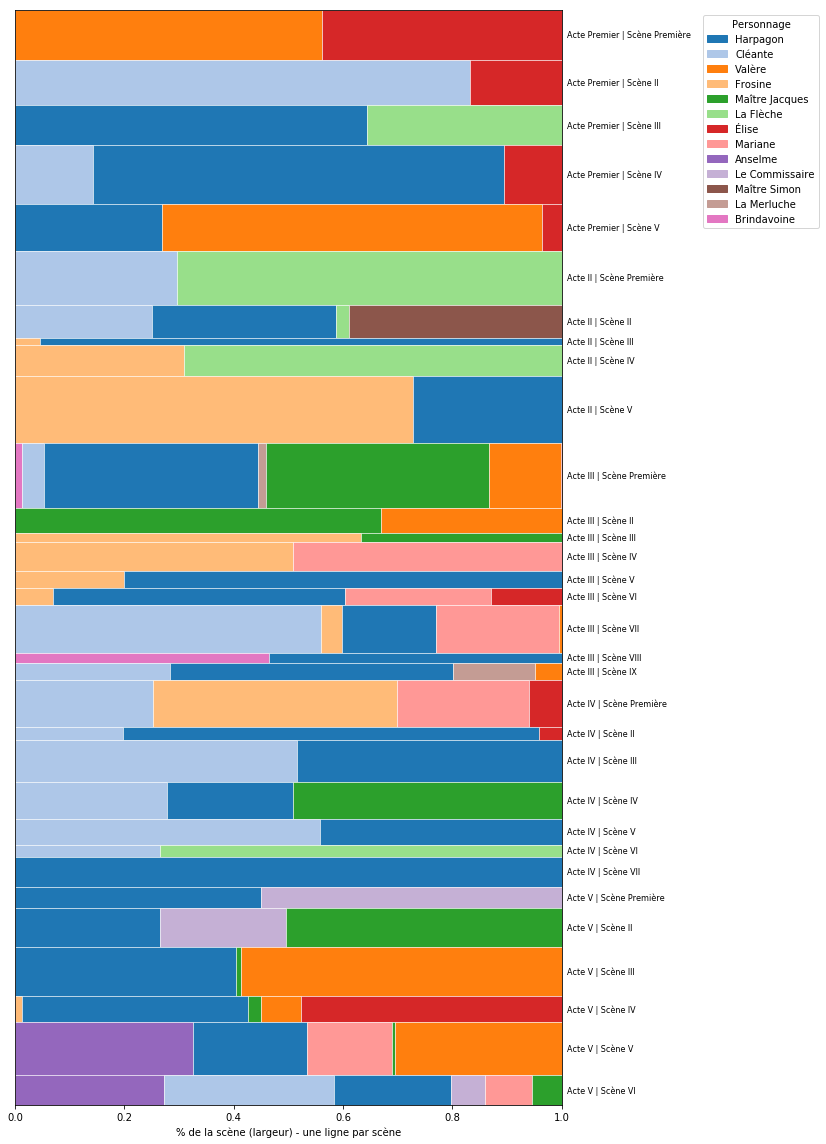

In [20]:
# Ordonnancement des actes et des scènes
# On affichera les labels bruts ("Acte Premier") mais on utilisera un ordre "naturel"
scene_order = []

for act in list_acts():
    for sc in list_scenes(act=act["node"]):
        scene_order.append(f"{act['title']} | {sc['title']}")

# Préparation des données
df = df_counts.copy()

# Création d'une clé unique pour identifier un couple acte/scène
# Cela permet de forcer l'ordre d'affichage, au lieu de suivre un ordre alphabétique
# qui noierait "Acte Premier" au milieu de la liste, par exemple
df["SceneKey"] = pd.Categorical(df["Acte"] + " | " + df["Scène"], categories=scene_order, ordered=True)

# Obtention du pourcentage que représente un dialogue particulier au sein d'une scène
df["share"] = df["Mots"] / df.groupby("SceneKey")["Mots"].transform("sum")

# Calcul du total de mots pour une scène donnée
totals = df.groupby("SceneKey")["Mots"].sum()

# Paramétrage du graphique
gap = 0 # Espace vertical ajouté entre deux scènes
label_fs = 8 # Taille de la police des étiquettes
min_target = 10  # Hauteur minimale souhaitée

# Définition de la hauteur d'une scène.
# Nous utilisons ici une fonction racine carré.
# Le but de ce calcul est d'éviter que les scènes contenant le moins de mots
# se trouvent compressées en une ligne si fine qu'il ne serait pas possible
# de distinguer les différents protagonistes.
# On sacrifie donc le rapport proportionnel strict au profit d'une meilleure
# lisibilité.
def scene_height(total):
    return max(min_target, math.sqrt(total) * factor)

create_actors_colormap(df["Personnage"].unique())

# Calcul de l'échelle des scènes : évite qu'une scène courte soit
# représentée par une ligne trop fine pour être distinguée
min_total = totals.min()
factor = min_target / math.log1p(min_total)

figure, axis = plt.subplots(figsize=(12, len(scene_order) * 0.5))

# Affichage de la colormap des personnages
handles = [mpatches.Patch(color=col, label=name) for name, col in color_map.items()]
axis.legend(handles=handles, title="Personnage", bbox_to_anchor=(1.25, 1), loc="upper left")

y = 0 # "Curseur" vertical permettant de positionner les scènes

# Traçage des scènes
for scene in scene_order:
    scene_rows = df[df["SceneKey"] == scene]
    h = scene_height(totals.loc[scene])

    left = 0

    for _, row in scene_rows.iterrows():
        # broken_barth est la méthode nous permettant de tracer des barres
        # horizontales juxtaposés
        axis.broken_barh([(left, row["share"])], (y, h),
                       facecolors=color_map[row["Personnage"]],
                       edgecolors="white", linewidth=0.5)

        # Décalage horizontal de la prochaine barre
        left += row["share"]

    # Étiquette correspondant à la scène
    axis.text(1.01, y + h/2, scene, va="center", fontsize=label_fs)

    # Décalage vertical de la prochaine scène
    y += h + gap

axis.set_xlim(0, 1)
axis.set_ylim(0, y)
axis.invert_yaxis()  # Acte I en haut
axis.set_xlabel("% de la scène (largeur) - une ligne par scène")
axis.set_yticks([]) # On masque l'ordonnée à gauche
plt.tight_layout()

L'ordre des dialogues est respecté sur ce graphique, contrairement au graphique de l'OBVIL.
Par exemple, dans la deuxième scène du premier acte, Cléante est bien la première à prendre la parole, et non Élise.

## Graphe réseau des dialogues

Ici, nous allons représenter les dialogues par un graphe réseau.
Nous allons essayer de reproduire le [graphe](https://obtic.huma-num.fr/obvil-web/corpus/moliere/moliere_avare) proposé par l'OBVIL.

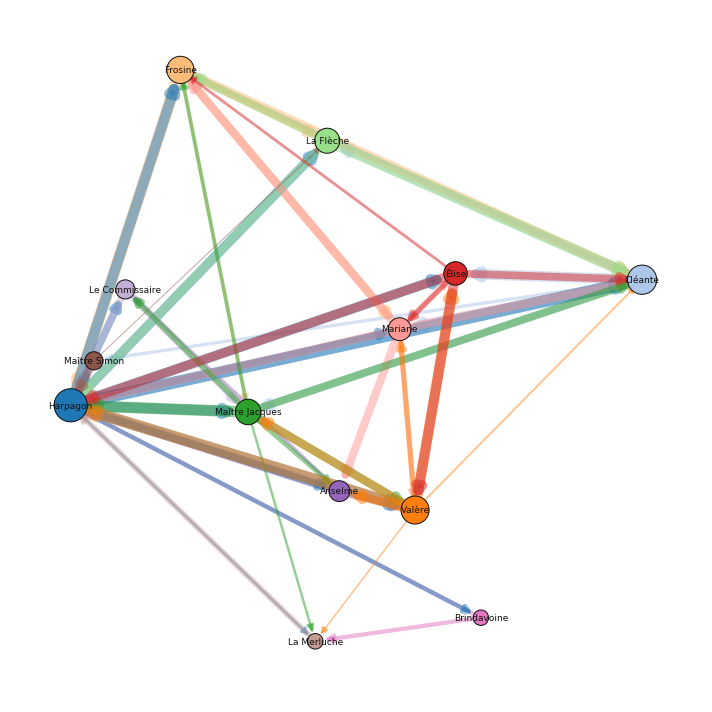

In [21]:
# 0. Fonction pour construire les arêtes d'interlocution
def interlocution_edges(df_speeches):
    """Arêtes directionnelles source -> cible : succession des locuteurs par scène."""
    df = df_speeches.copy()
    df["SceneKey"] = df["Acte"] + " | " + df["Scène"]
    df["order"] = range(len(df))
    df = df.sort_values(["SceneKey", "order"])
    df["next"] = df.groupby("SceneKey")["Personnage"].shift(-1)

    return (df.dropna(subset=["next"])
              .groupby(["Personnage", "next"], as_index=False)["Mots"]
              .sum()
              .rename(columns={"Personnage": "source", "next": "target", "Mots": "weight"}))

# 1. Données de base
totaux = df_speeches.groupby("Personnage")["Mots"].sum()
edges_dir = interlocution_edges(df_speeches)

# 2. Construction du graphe NetworkX
G = nx.DiGraph()

# Nœuds : taille ~ mots, couleur issue de color_map
for personnage, mots in totaux.items():
    taille = 8 + 0.6 * np.sqrt(mots)  # on ne calcule plus cette formule qu'ici
    G.add_node(
        personnage,
        mots=int(mots),
        label=personnage,
        color=mcolors.to_hex(color_map.get(personnage)) if color_map.get(personnage) else "#cccccc",
        size=taille,
    )

# Arêtes dirigées : poids log1p, couleur héritée de la source
for _, r in edges_dir.iterrows():
    if r["source"] == r["target"]:
        continue

    src = r["source"]
    tgt = r["target"]
    w = int(r["weight"])

    G.add_edge(
        src,
        tgt,
        weight=w,
        log_weight=float(np.log1p(w)),
        color=mcolors.to_hex(color_map.get(src)) if color_map.get(src) else "#999999",
        label=f"{src} → {tgt} : {w} mots",
    )

# 3. Préparation du GraphRenderer Bokeh
node_names = list(G.nodes())
node_indices = list(range(len(node_names)))
name_to_index = {name: i for i, name in enumerate(node_names)}

graph = GraphRenderer()

# ----- NŒUDS -----
mots_list = [G.nodes[n]["mots"] for n in node_names]
sizes = [G.nodes[n]["size"] for n in node_names]   # on réutilise la taille déjà calculée
max_size = max(sizes) if sizes else 1

# radius en coordonnées "data" (échelle relative)
radii = [0.03 + 0.12 * (s / max_size) for s in sizes]

graph.node_renderer.data_source.data = dict(
    index=node_indices,
    name=node_names,
    label=[G.nodes[n]["label"] for n in node_names],
    mots=mots_list,
    color=[G.nodes[n]["color"] for n in node_names],
    radius=radii,
)

graph.node_renderer.glyph = Circle(
    radius="radius",
    fill_color="color",
    line_width=1.2,
)

# ----- ARÊTES -----
edge_start = []
edge_end = []
edge_weight = []
edge_log_weight = []
edge_color = []
edge_label = []

for u, v in G.edges():
    edge_start.append(name_to_index[u])
    edge_end.append(name_to_index[v])
    edge_weight.append(G[u][v]["weight"])
    edge_log_weight.append(G[u][v]["log_weight"])
    edge_color.append(G[u][v]["color"])   # couleur de la source
    edge_label.append(G[u][v]["label"])

# largeur des arêtes normalisée (contraste lisible)
if edge_log_weight:
    min_log = min(edge_log_weight)
    max_log = max(edge_log_weight)
    if max_log == min_log:
        edge_line_width = [5.0 for _ in edge_log_weight]
    else:
        edge_line_width = [
            1.0 + 11.0 * (lw - min_log) / (max_log - min_log)
            for lw in edge_log_weight
        ]
else:
    edge_line_width = []

graph.edge_renderer.data_source.data = dict(
    start=edge_start,
    end=edge_end,
    weight=edge_weight,
    log_weight=edge_log_weight,
    edge_color=edge_color,
    line_width=edge_line_width,
    label=edge_label,
)

graph.edge_renderer.glyph = MultiLine(
    line_color="edge_color",
    line_width="line_width",
    line_alpha=0.25,   # « fond » des arêtes
)

# 4. Layout (positions des nœuds)

LAYOUT_SEED = 42  # layout stable d’une exécution à l’autre

pos = nx.spring_layout(
    G,
    k=2,
    iterations=200,
    weight="log_weight",
    seed=LAYOUT_SEED,
)

# Rayons par nœud (en coordonnées data)
node_radius = dict(zip(node_names, radii))

# Gros personnages = au-dessus du 75e centile
mots_arr = np.array(mots_list)
seuil_gros = np.quantile(mots_arr, 0.75) if len(mots_arr) > 0 else 0
big_nodes = [n for n, m in zip(node_names, mots_list) if m >= seuil_gros]

big_sep_factor = 5.0  # écartement spécifique entre gros nœuds

for _ in range(10):
    moved = False
    for i in range(len(big_nodes)):
        for j in range(i + 1, len(big_nodes)):
            ni = big_nodes[i]
            nj = big_nodes[j]

            pi = np.array(pos[ni], dtype=float)
            pj = np.array(pos[nj], dtype=float)

            diff = pj - pi
            dist = np.linalg.norm(diff)
            if dist == 0:
                diff = np.random.randn(2)
                dist = np.linalg.norm(diff)

            min_dist = big_sep_factor * (node_radius[ni] + node_radius[nj])

            if dist < min_dist:
                direction = diff / dist
                center = (pi + pj) / 2.0
                offset = direction * (min_dist / 2.0)

                pos[ni] = (center - offset).tolist()
                pos[nj] = (center + offset).tolist()
                moved = True
    if not moved:
        break

graph_layout = {name_to_index[name]: pos[name] for name in node_names}
graph.layout_provider = StaticLayoutProvider(graph_layout=graph_layout)

xs = [p[0] for p in pos.values()]
ys = [p[1] for p in pos.values()]
if xs and ys:
    margin = 0.3 * max(max(xs) - min(xs), max(ys) - min(ys))
    x_min, x_max = min(xs) - margin, max(xs) + margin
    y_min, y_max = min(ys) - margin, max(ys) + margin
else:
    x_min, x_max, y_min, y_max = -2, 2, -2, 2

# 5. Figure Bokeh + Hover

plot = bkp.figure(
    width=900,
    height=700,
    x_range=(x_min, x_max),
    y_range=(y_min, y_max),
    title="Graphe des interlocutions",
    tools="pan,wheel_zoom,box_zoom,reset,save",
    active_scroll="wheel_zoom",
    background_fill_color="#f8f8f8",
)

plot.renderers.append(graph)

# Hover nœuds
hover_nodes = HoverTool(
    tooltips=[
        ("Personnage", "@label"),
        ("Mots totaux", "@mots"),
    ],
    renderers=[graph.node_renderer],
)
plot.add_tools(hover_nodes)

# Hover arêtes (corps)
hover_edges = HoverTool(
    tooltips=[
        ("Interaction", "@label"),
        ("Mots", "@weight"),
    ],
    renderers=[graph.edge_renderer],
)
plot.add_tools(hover_edges)

# 6. Flèches (orientation)

layout_xy = {name: pos[name] for name in node_names}

x_start, y_start, x_end, y_end, lw_arrow, colors = [], [], [], [], [], []
for (u, v), w, c in zip(G.edges(), edge_line_width, edge_color):
    x0, y0 = layout_xy[u]
    x1, y1 = layout_xy[v]
    x_start.append(x0)
    y_start.append(y0)
    x_end.append(x1)
    y_end.append(y1)
    lw_arrow.append(w)
    colors.append(c)   # couleur du personnage source

arrow_source = ColumnDataSource(dict(
    x_start=x_start,
    y_start=y_start,
    x_end=x_end,
    y_end=y_end,
    line_width=lw_arrow,
    color=colors,
))

arrows = Arrow(
    end=NormalHead(
        size=7,
        fill_color="color",
        line_color="color",
        fill_alpha=1.0,
        line_alpha=1.0,
    ),
    x_start="x_start",
    y_start="y_start",
    x_end="x_end",
    y_end="y_end",
    line_width="line_width",
    line_color="color",
    line_alpha=0.5,
    source=arrow_source,
)
plot.add_layout(arrows)

# 7. Labels sur les nœuds

node_x = [graph_layout[i][0] for i in node_indices]
node_y = [graph_layout[i][1] for i in node_indices]

labels_source = ColumnDataSource(dict(
    x=node_x,
    y=node_y,
    label=[G.nodes[n]["label"] for n in node_names],
))

labels = LabelSet(
    x="x",
    y="y",
    text="label",
    source=labels_source,
    text_align="center",
    text_baseline="middle",
    text_font_size="9pt",
    text_color="#111111",
)
plot.add_layout(labels)

show(plot)

# Version statique

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_axis_off()

# Nœuds : réutilise la taille et la couleur déjà stockées dans G
node_sizes = [G.nodes[n]["size"] * 20 for n in G.nodes()]  # facteur à ajuster visuellement
node_colors = [G.nodes[n]["color"] for n in G.nodes()]

nx.draw_networkx_nodes(
    G,
    pos,
    ax=ax,
    node_size=node_sizes,
    node_color=node_colors,
    linewidths=1.0,
    edgecolors="#111111",
)

# Arêtes : on réutilise largeur et couleur calculées pour Bokeh
edges = list(G.edges())

nx.draw_networkx_edges(
    G,
    pos,
    ax=ax,
    edgelist=edges,
    width=edge_line_width,
    edge_color=edge_color,
    arrows=True,
    arrowstyle="-|>",
    arrowsize=15,
    alpha=0.5,
)

# Labels : mêmes labels que dans Bokeh
labels = {n: G.nodes[n]["label"] for n in G.nodes()}
nx.draw_networkx_labels(
    G,
    pos,
    labels=labels,
    ax=ax,
    font_size=9,
    font_color="#111111",
)

plt.tight_layout()
plt.show()

La pile logicielle employée par l'OBVIL pour son propre graphique repose sur Sigma et ForceAtlas2, des modules `nodejs` que je ne souhaitais pas exploiter dans ce notebook.
Nous avons choisi d'exploiter la librairie bokeh pour sa popularité et sa maintenance active, ainsi que sa disponibilité dans cette instance de Jupyter Lab.

## Conclusion

Cette étude a révélé que malgré tout le soin que l'on peut apporter au traitement d'un sujet spécifique, il est possible d'introduire involontairement des "artefacts" dans les données sur lesquelles on travaille. 
Ici, il s'agit de différences d'orthographes mineures, invisibles lors d'une lecture par un humain, mais qui peuvent rendre une étude assistée par l'informatique plus complexe, voire sujette aux erreurs.
On le répète assez souvent en informatique (et particulièrement en développement web) : on ne doit jamais avoir confiance dans les entrées...
Cela a nécessité un travail assez important en amont, et il faut préciser que ce n'est pas infaillible.

Une autre source potentielle d'erreur, que ce soit au niveau de l'analyse ou de l'interprétation, consiste en des définitions ou des méthodologies différentes.
Ici, nous avons calculé des statistiques divergentes de celles de l'OBVIL, probablement en raison d'une définition différente de ce qu'est une "ligne".
Pour notre étude, nous considérons qu'une ligne est une suite de 60 caractères, dont les espaces surnuméraires ont été supprimés (incluant les sauts de lignes).

Or, ce n'est qu'après une inspection plus poussée du dépôt de l'outil [dramagraph](https://github.com/dramacode/dramagraph/tree/gh-pages) de l'OBLIV révèle la méthode : après "nettoyage" des fichiers TEI source par l'emploi d'une [feuille de style XSL](https://github.com/dramacode/dramagraph/blob/gh-pages/naked.xsl), [un autre fichier XSL](https://github.com/dramacode/dramagraph/blob/gh-pages/drama2csv.xsl#L517) est en charge, notamment, du formatage des paragraphes (séparés par des retours de ligne), de la [gestion des accents](https://github.com/dramacode/dramagraph/blob/gh-pages/drama2csv.xsl#L14) et de [la casse](https://github.com/dramacode/dramagraph/blob/gh-pages/drama2csv.xsl#L524), et enfin de la production [des compteurs](https://github.com/dramacode/dramagraph/blob/gh-pages/drama2csv.xsl#L490).

Par conséquent, pour retrouver des statistiques identiques à l'OBVIL, il aurait fallut passer par le même _pipeline_.
On aurait du choisir d'utiliser le TEI comme fichier source et lui appliquer les mêmes fichiers XSL, ce qui nous aurait donné directement accès aux statistiques, sans avoir besoin de les recalculer nous-même, réduisant considérablement la taille de ce notebook.

On en déduit finalement que :

- l'enthousiasme est parfois un ennemi ! J'aurai du prendre davantage de temps pour examiner comment l'OBVIL a produit ses statistiques, avant de me lancer dans une étude personnelle
- bien que structuré, HTML est un "produit transformé" : les fichiers TEI ont manifestement servi comme base à tous les autres formats proposés par l'OBVIL ; j'aurai du l'identifier comme source idéale